In [36]:
%load_ext blackcellmagic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import root_scalar
plt.style.use("ggplot")
plt.rcParams['font.family'] = "serif"
plt.rc('text', usetex=True)
from numba import jit

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [78]:
@jit
def numerov(e: float,
            l: int   = 0,
            h: float = 0.001,
         xmax: float = 50,
            M: int   = 3):
    x = np.arange(0, xmax, h)
    y = np.zeros_like(x)
    kk = np.zeros_like(x)
    #priprava koeficientov za numerova:
    if l == 0:
        koefs = [0,1,-1, (2-e)/6, (-1+2*e)/18, (2-10*e+3*e**2)/360]
    elif l == 1:
        koefs = [0,0,1,-0.5, (1-e)/10, (-2+7*e)/180]
    elif l == 2:
        koefs = [0,0,0,1,-1/3, (2-3*e)/42, (-1+5*e)/252]
    else:
        raise AttributeError("Nimam koeficientov za l not in [0,1,2]!")
    def taylor(x):
        global e
        vsota = 0
        for i, k in enumerate(koefs):
            vsota += k*x**i
        return vsota

    kk = 2/x-l*(l+1)/x**2+e
    for i, _ in enumerate(y):
        if i < M:
            y[i] = taylor(x[i])
        else:
            y[i] = (2* (1-5/12*(h**2)*kk[i-1])*y[i-1] - (1+kk[i-2]*(h**2)/12)*y[i-2])/(
                    1+(h**2)/12*kk[i])

    return x,y
        

0.9969780681896254


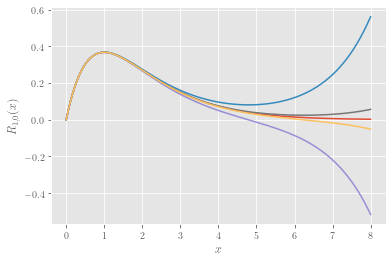

In [79]:
%matplotlib inline
XMAX = 8

x,y = numerov(-1, xmax=XMAX)
integral = np.trapz(np.abs(y), x=x)
print(integral)
plt.plot(x,y, label=r"$e=-1$")

x,y = numerov(-1.01, xmax=XMAX)
plt.plot(x,y, label=r"$e=-1.01$")
#plt.text(5, 0.2, r"$e=-1.01$")


x,y = numerov(-0.99, xmax=XMAX)
plt.plot(x,y, label=r"$e=-0.99$")
#plt.text(5, -0.2, r"$e=-0.99$")


x,y = numerov(-1.001, xmax=XMAX)
plt.plot(x,y, label=r"$e=-1.001$")
#plt.text(7, 0.1, r"$e=-1.001$")

x,y = numerov(-0.999, xmax=XMAX)
plt.plot(x,y, label=r"$e=-0.999$")
#plt.text(7, -0.1, r"$e=-0.999$")
plt.xlabel(r"$x$")
plt.ylabel(r"$R_{1,0}(x)$")
#plt.savefig("1-R10.pdf")
plt.show()

In [4]:
eji = -1*np.logspace(0.1, -5, 10000)
koncni_y = np.zeros_like(eji)
for i, e in enumerate(eji):
    x,y = numerov(e, xmax=8, M=3)
    koncni_y[i] = y[-1]

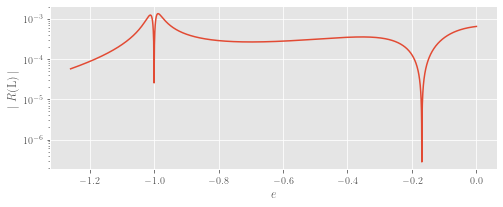

In [5]:
%matplotlib inline
plt.figure(figsize=(8, 3))
plt.plot(eji, np.abs(koncni_y))
plt.semilogy()
plt.xlabel(r"$e$")
plt.ylabel(r"$\mid R(\mathrm{L})\mid $")
#plt.savefig("1-absolutne.pdf")
plt.show()

In [6]:
def func_to_minimize(e):
    x,y = numerov(e, xmax=500)
    return y[-1]


In [7]:
expected_roots = [-1/n**2 for n in [1,2,3,4,5,6,7,8]]
brackets = [[0.9*i, 1.1*i] for i in expected_roots]
for bra, expected in zip(brackets, expected_roots):
    try:
        res = root_scalar(func_to_minimize, bracket=bra)
        print(f"Exact:\t{expected:20.15f} \tFound:\t{res.root:20.15f}")
    except Exception as e:
        print(e)

Exact:	  -1.000000000000000 	Found:	  -0.900000000000000
Exact:	  -0.250000000000000 	Found:	  -0.249999999999500
Exact:	  -0.111111111111111 	Found:	  -0.111111111110452
Exact:	  -0.062500000000000 	Found:	  -0.062499999999937
Exact:	  -0.040000000000000 	Found:	  -0.039999999999342
Exact:	  -0.027777777777778 	Found:	  -0.027777777777607
Exact:	  -0.020408163265306 	Found:	  -0.020408163263333
Exact:	  -0.015625000000000 	Found:	  -0.015624999998879


### Evalvacija parametrov 

In [8]:
from functools import lru_cache

@lru_cache(maxsize=1024)
def get_error_of_numerov(xmax, h):
    def func_to_minimize(e, xmax, h):
        x,y = numerov(e, xmax=xmax, h=h)
        return y[-1]
    res = root_scalar(func_to_minimize, bracket=[-1.01, -0.99], args=(xmax, h))
    return np.log10(abs(res.root+1))



In [9]:
M = 30

def get_errors(M):
    xmaxes = np.linspace(6, 30, M)
    hs = np.logspace(-5, -1, M)
    zz = np.zeros((M,M))
    for i, xm in enumerate(xmaxes):
        for j, h in enumerate(hs):
            zz[i,j] = get_error_of_numerov(xm, h)
            print(i, j, end="\r")
    return xmaxes, hs, zz
xmaxes, hs, zz = get_errors(M)

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(dpi=300)

p = ax.contourf(xmaxes, hs, zz)
fig.colorbar(p)
ax.set_title("Napaka integracije")
ax.set_yscale("log")
ax.set_ylabel(r"Korak $h$")
ax.set_xlabel(r"Dolžina integracije")

plt.savefig("2020_1-napaka_integracije2.pdf")

In [ ]:
zz.savetxt(f"1-data{M}.txt")

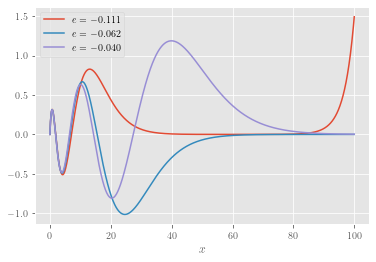

In [57]:
%matplotlib inline

for e in [-1/i**2 for i in range(3, 6)]:    
    x,y = numerov(e, xmax=100, l=0, h=0.0001)
    plt.plot(x,y, label=fr"$e={e:.3f}$")

plt.legend()

plt.xlabel(r"$x$")
#plt.savefig("1-R10.pdf")
plt.show()

# Drugi del:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


#najprej lomni količnik
def n(x):
    if x<1:
        n=2-0.5*x*x
        return n
    else:
        n=1
        return n


#definicija začetnih dveh točk
def a0():
    return 1

def a2(l,k):
    return (1/4)*(l*l-4*k*k)

def a4(l,k):
    return (1/64)*(8*k*k +16*k*k*k*k -8*k*k*l*l + l*l*l*l)

def K(x,k,l):
    return (1/(4*x*x)) + n(x)*n(x)*k*k -l*l

h=0.0001
k=2
L=np.arange(3,20,0.1)

Y=[]
XX=[]
j=0
for l in L:
    y=[np.sqrt(h)*(a0() + a2(l,k)*h*h + a4(l,k)*h*h*h*h),
       np.sqrt(2*h)*(a0() + a2(l,k)*h*h*4 + a4(l,k)*h*h*h*h*16)]
    x=[h,2*h]
    i = 0
    d = 0
    while np.abs(d) < 20:
        a = 2 * (1 - (5 / 12) * (h ** 2) * K(2 * h + i * h, k, l)) * y[i + 1]
        b = (1 + ((h ** 2) / 12) * K(h + i * h, k, l)) * y[i]
        c = 1 + ((h ** 2) / 12) * K(3 * h + i * h, k, l)
        d=(a - b) / c
        x.append(3 * h + i * h)
        y.append(d)
        X = 3*h + i*h
        i = i + 1


    Y.append(d)
    XX.append(X)
    j = j + 1

plt.figure(0)
plt.plot(L,Y,alpha=0.7,label='k=2')
plt.legend(loc=0,frameon=False)
plt.ylabel('amplituda divergence')
plt.xlabel(r'$\lambda$')
#plt.savefig('propagacija_svetlobe_0_0.png')
plt.show()





k=2
L=np.arange(3,3.4,0.002)

Y=[]
XX=[]
j=0
for l in L:
    y=[np.sqrt(h)*(a0() + a2(l,k)*h*h + a4(l,k)*h*h*h*h),
       np.sqrt(2*h)*(a0() + a2(l,k)*h*h*4 + a4(l,k)*h*h*h*h*16)]
    x=[h,2*h]
    i = 0
    d = 0
    while np.abs(d) < 20:
        a = 2 * (1 - (5 / 12) * (h ** 2) * K(2 * h + i * h, k, l)) * y[i + 1]
        b = (1 + ((h ** 2) / 12) * K(h + i * h, k, l)) * y[i]
        c = 1 + ((h ** 2) / 12) * K(3 * h + i * h, k, l)
        d=(a - b) / c
        x.append(3 * h + i * h)
        y.append(d)
        X = 3*h + i*h
        i = i + 1


    Y.append(d)
    XX.append(X)
    print(Y[j], l, X)
    j = j + 1

plt.figure(1)
plt.plot(L,Y,alpha=0.7,label='k=2')
plt.axhline(y=0,color='black')
plt.grid()
plt.legend(loc=0,frameon=False)
plt.ylabel('amplituda divergence')
plt.xlabel(r'$\lambda$')
#plt.savefig('propagacija_svetlobe_0_1.png')
plt.show()

In [134]:
@jit
def numerov2(k: int, lambd: float, h: float = 0.001, xmax: float = 20):
    M = 3
    x = np.arange(h, xmax, h)
    y = np.zeros_like(x)
    kk = np.zeros_like(x)
    # priprava koeficientov za numerova:
    koefs = [1, 0, (lambd**2 - 4*k**2)/4, 0, 1/64 * (8*k**2 + 16*k**4 - 8*k**2 * lambd**2 + lambd**4)]
    def n(x):
        return np.where(x>1, 1, 2-0.5*x**2)
    def taylor(x):
        vsota = 0
        for i, k in enumerate(koefs):
            vsota += k * x ** i
        return vsota

    kk = 1/(4*x**2) + (n(x))**2 * (k**2) - lambd**2 
    for i, _ in enumerate(y):
        if i < M:
            y[i] = x[i]**0.5 * taylor(x[i])
        else:
            y[i] = (
                2 * (1 - 5 / 12 * h ** 2 * kk[i - 1]) * y[i - 1]
                - (1 + kk[i - 2] * h ** 2 / 12) * y[i - 2]
            ) / (1 + h ** 2 / 12 * kk[i])
    return x, y

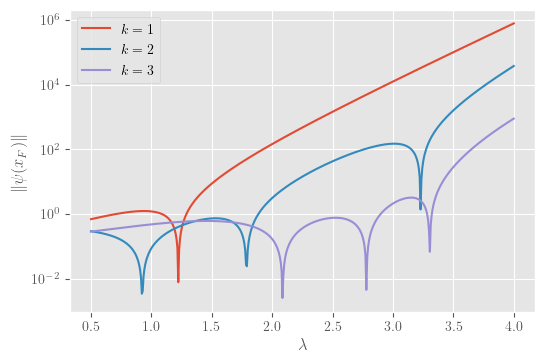

In [135]:
lambdas = np.linspace(0.5, 4, 500)
ends = np.empty_like(lambdas)
plt.figure(dpi=100)
for k in range(1, 4):
    for i, lambd in enumerate(lambdas):
        x, y = numerov2(k, lambd, xmax=4)
        ends[i] = y[-1]
    plt.plot(lambdas, np.abs(ends),label=f"$k={k}$")
plt.semilogy()
plt.legend()
plt.ylabel(r"$\| \psi(x_F) \|$")
plt.xlabel("$\lambda$")
plt.savefig("2021-2-magnitude.pdf")
plt.show()

In [144]:
from scipy.signal import find_peaks
lambdas[find_peaks(-1*np.log(np.abs(ends)), )[0]]

array([2.08517034, 2.77955912, 3.30561122])

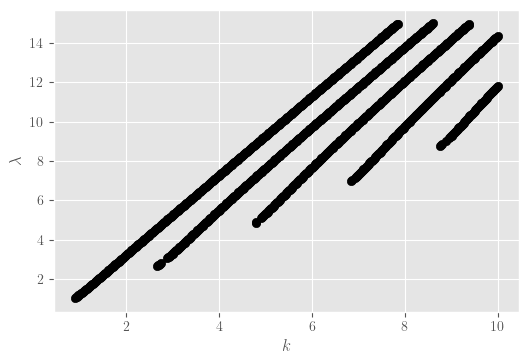

In [162]:
ks = np.linspace(0.8, 10, 500)
plt.figure(dpi=100)
for k in ks:
    found_lambdas = []
    def func_to_minimize(lambd):
        x,y = numerov2(k, lambd, xmax=10)
        return y[-1]
    lambdas = np.linspace(0.5, 15, 1000)
    ends = np.empty_like(lambdas)
    for i, lambd in enumerate(lambdas):
        x, y = numerov2(k, lambd, xmax=4)
        ends[i] = y[-1]
    crois = lambdas[find_peaks(-1*np.log(np.abs(ends)), )[0]] # Centers of ROIs
    for croi in crois:
        if croi < k:
            continue
        try:
            res = root_scalar(func_to_minimize, bracket=[croi-0.2, croi+0.2])
            # print(f"{k=}", res.root)
            if res.root > k:
                found_lambdas.append(res.root)
        except ValueError:
            continue
    plt.scatter([k for i in found_lambdas], found_lambdas, c = "k")
plt.ylabel("$\lambda$")
plt.xlabel("$k$")
plt.savefig("2021_disperzija.pdf")
plt.show()


In [163]:
def find_lambda(k):
    found_lambdas = []
    def func_to_minimize(lambd):
        x,y = numerov2(k, lambd, xmax=10)
        return y[-1]
    lambdas = np.linspace(0.5, 15, 1000)
    ends = np.empty_like(lambdas)
    for i, lambd in enumerate(lambdas):
        x, y = numerov2(k, lambd, xmax=4)
        ends[i] = y[-1]
    crois = lambdas[find_peaks(-1*np.log(np.abs(ends)), )[0]] # Centers of ROIs
    for croi in crois:
        if croi < k:
            continue
        try:
            res = root_scalar(func_to_minimize, bracket=[croi-0.2, croi+0.2])
            # print(f"{k=}", res.root)
            if res.root > k:
                found_lambdas.append(res.root)
        except ValueError:
            continue
    return found_lambdas



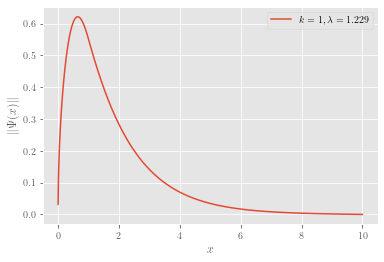

In [181]:
for k in range(1,2):
    lambdas = find_lambda(k)
    for i, lambd in enumerate(lambdas):
        if lambd < k:
            continue
        x, y = numerov2(k, lambd, xmax=10)
        plt.plot(x, y,label=f"$k={k}, \lambda = {lambd:1.3f}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$\|\Psi(x) \|$")
plt.savefig("2021_funkcije1.pdf")
plt.show()

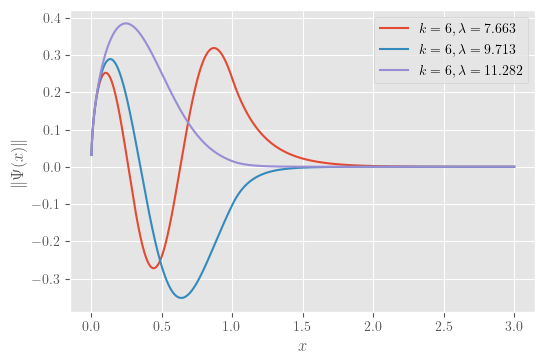

In [186]:
plt.figure(dpi=100)
for k in range(6,7):
    lambdas = find_lambda(k)
    for i, lambd in enumerate(lambdas):
        if lambd < k:
            continue
        x, y = numerov2(k, lambd, xmax=3)
        plt.plot(x, y,label=f"$k={k}, \lambda = {lambd:1.3f}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$\|\Psi(x) \|$")
plt.savefig("2021_funkcije6.pdf")
plt.show()

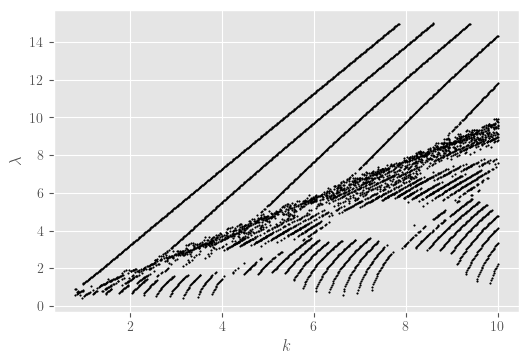

In [188]:
ks = np.linspace(0.8, 10, 500)
rez = dict()
plt.figure(dpi=100)
for k in ks:
    found_lambdas = []
    def func_to_minimize(lambd):
        x,y = numerov2(k, lambd, xmax=20)
        return y[-1]
    lambdas = np.linspace(0.5, 15, 400)
    ends = np.empty_like(lambdas)
    for i, lambd in enumerate(lambdas):
        x, y = numerov2(k, lambd, xmax=10)
        ends[i] = y[-1]
    crois = lambdas[find_peaks(-1*np.log(np.abs(ends)), )[0]] # Centers of ROIs
    for croi in crois:
        try:
            res = root_scalar(func_to_minimize, bracket=[croi-0.2, croi+0.2])
            # print(f"{k=}", res.root)
            found_lambdas.append(res.root)
        except ValueError:
            continue
    rez[k]  = found_lambdas
    plt.scatter([k for i in found_lambdas], found_lambdas, s=1, c = "k")
plt.ylabel("$\lambda$")
plt.xlabel("$k$")
plt.savefig("2021_disperzija_vsi.pdf")
plt.show()
